In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

COCO COLA Sales Forecasting

In [2]:
file_path = 'data/CocaCola_Sales_Rawdata.xlsx'
sheet_name = 'Sheet1'
cocacola_df = pd.read_excel(file_path, sheet_name=sheet_name)

In [3]:
cocacola_df.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


# Linear regression

In [4]:
df = cocacola_df.copy()
# Extract year and quarter, create dummy variables
df['Year'] = df['Quarter'].apply(lambda x: int(x.split('_')[1]))
df['Quarter'] = df['Quarter'].apply(lambda x: x.split('_')[0])

# Create dummy variables for quarters
quarter_dummies = pd.get_dummies(df['Quarter'], prefix='Quarter')

# Concatenate dummy variables with the original dataframe
df = pd.concat([df, quarter_dummies], axis=1)

# Drop the original Quarter column as it's no longer needed
df.drop('Quarter', axis=1, inplace=True)



# Define features and target
X = df.drop('Sales', axis=1)
y = df['Sales']



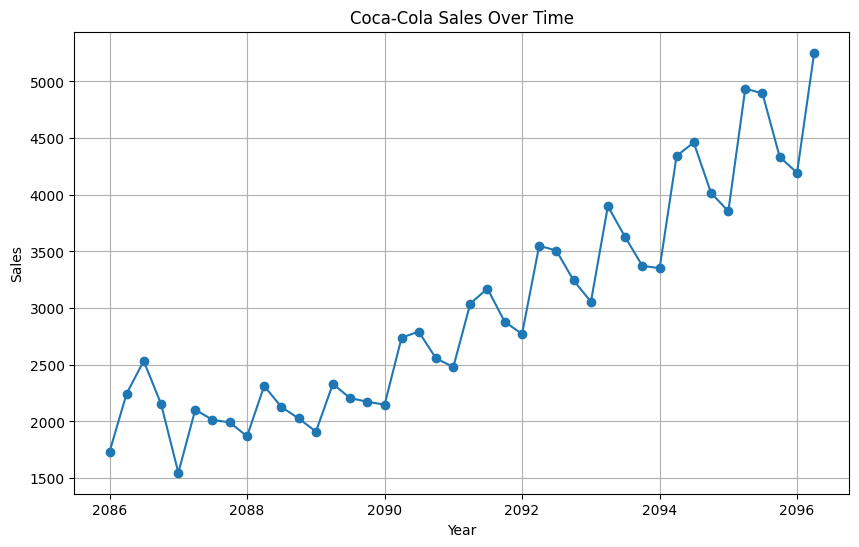

In [38]:
import matplotlib.pyplot as plt

# Plot the sales data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Sales'], marker='o', linestyle='-')
plt.title('Coca-Cola Sales Over Time')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


#### Basic Observation: It is clear that over years sales are increasing

In [5]:
X.head()

,Year,Quarter_Q1,Quarter_Q2,Quarter_Q3,Quarter_Q4
0,86,1,0,0,0
1,86,0,1,0,0
2,86,0,0,1,0
3,86,0,0,0,1
4,87,1,0,0,0


In [6]:
y.head()

0    1734.827000
1    2244.960999
2    2533.804993
3    2154.962997
4    1547.818996
Name: Sales, dtype: float64

## Dummy Variables:
 Dummy variables are used to represent categorical data in a numerical format, enabling machine learning models to interpret categorical information

## 4 Dummy variables are created
 Created dummy variables for the 'Quarter' column, each unique quarter entry ('Q1', 'Q2', 'Q3', 'Q4') will generate three dummy variables due to the use of one-hot encoding:

##### 'Quarter_Q1': Indicates if the quarter is 'Q1'.
##### 'Quarter_Q2': Indicates if the quarter is 'Q2'.
##### 'Quarter_Q3': Indicates if the quarter is 'Q3'.
##### 'Quarter_Q4': Indicates if the quarter is 'Q4'.

In [7]:
X.head()

,Year,Quarter_Q1,Quarter_Q2,Quarter_Q3,Quarter_Q4
0,86,1,0,0,0
1,86,0,1,0,0
2,86,0,0,1,0
3,86,0,0,0,1
4,87,1,0,0,0


In [8]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE (Root Mean Squared Error)
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 221.68319418452302


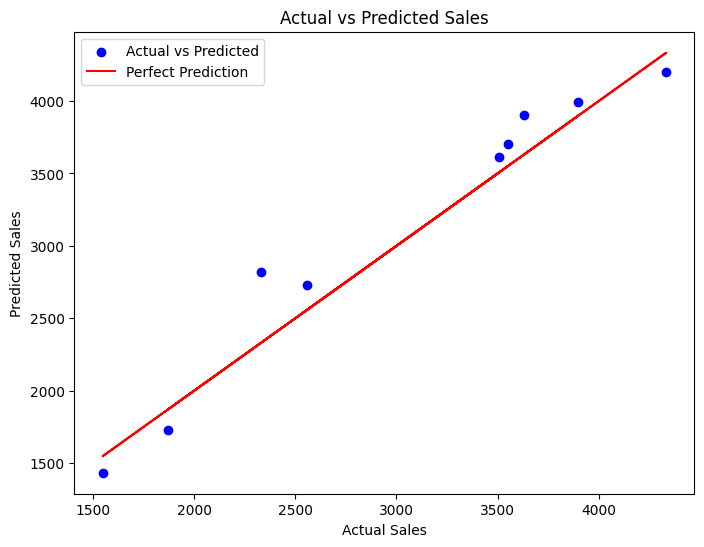

In [9]:

plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, color='blue', label='Actual vs Predicted')
plt.plot(y_test, y_test, color='red', label='Perfect Prediction')  # Perfect prediction line (y_test = predictions)
plt.title('Actual vs Predicted Sales')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.legend()
plt.show()



# Plots

# ACF plot

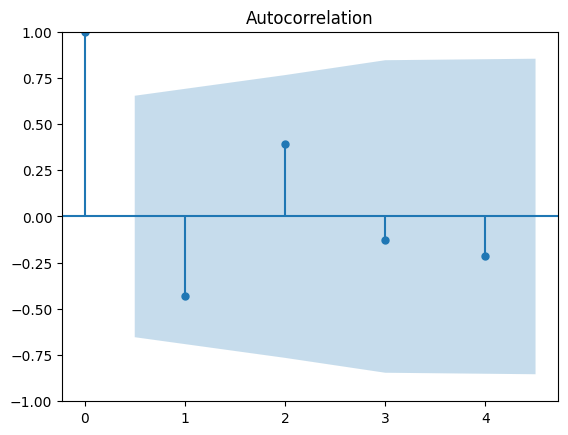

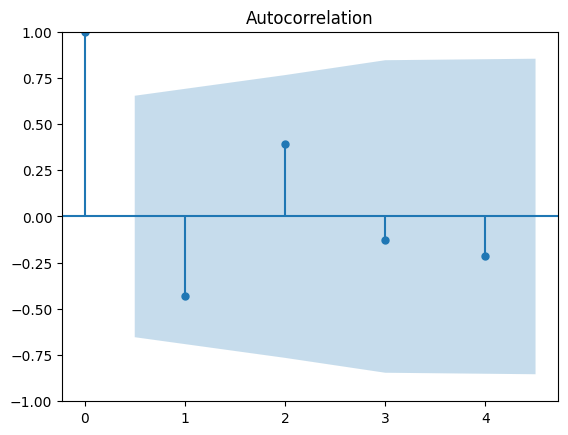

In [10]:


plot_acf(y_test)  # Plot ACF for the target variable



# PACF plot

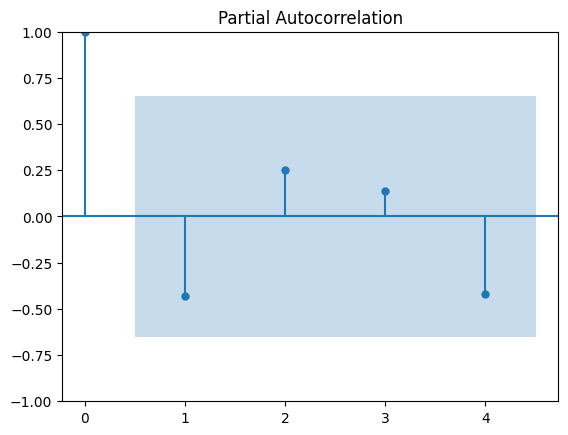

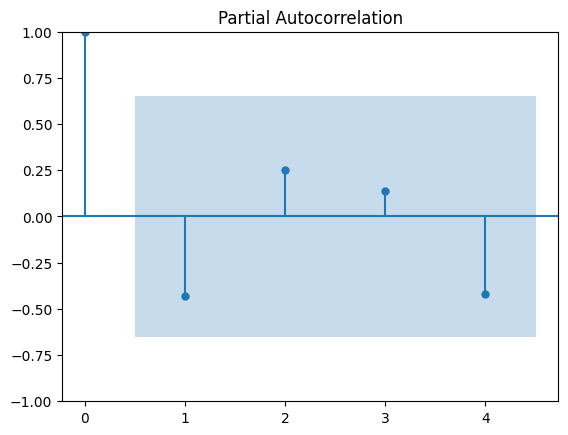

In [11]:
plot_pacf(y_test)  # Plot PACF for the target variable



# Time Series plot

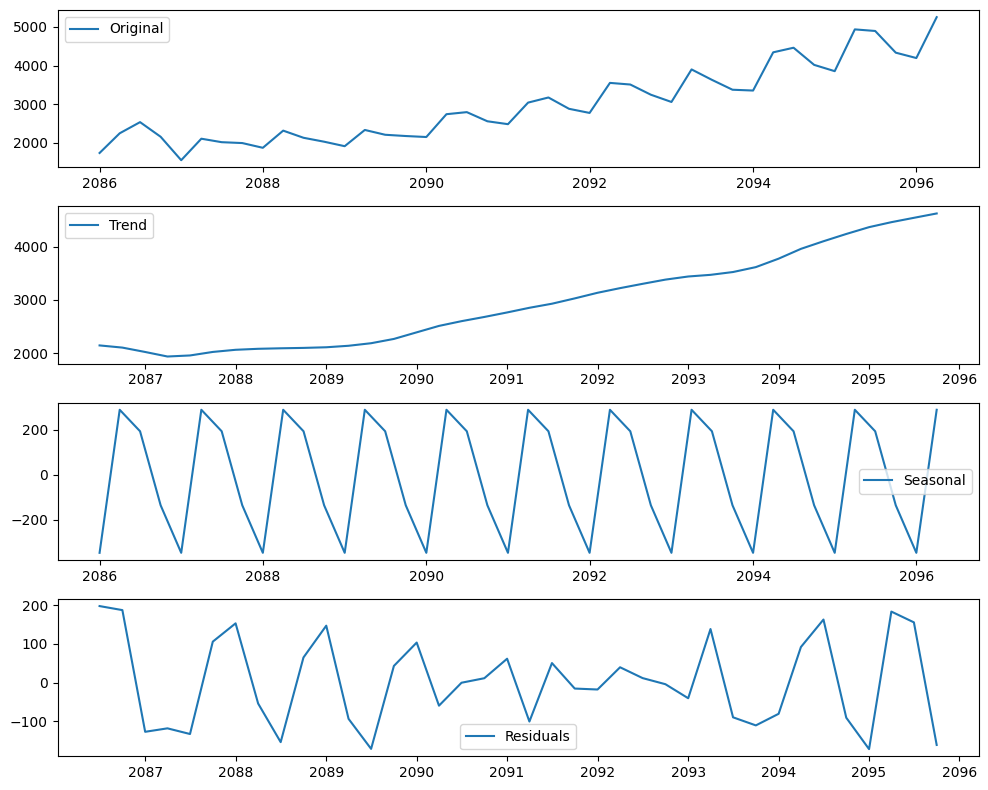

In [12]:

df = cocacola_df.copy()
# Extract year and quarter, create datetime index

df['Year'] = df['Quarter'].apply(lambda x: int(x.split('_')[1]))
df['Quarter'] = df['Quarter'].apply(lambda x: x.split('_')[0])
df['Date'] = df.apply(lambda x: pd.to_datetime(f'{x["Year"]}-{x["Quarter"][-2:]}'), axis=1)

# Drop unnecessary columns
df.drop(['Quarter', 'Year'], axis=1, inplace=True)
df.set_index('Date', inplace=True)
# Perform decomposition
df = df.ffill()
decomposition = seasonal_decompose(df, model='additive')

# Plot the decomposition
plt.figure(figsize=(10, 8))

# Original time series
plt.subplot(411)
plt.plot(df, label='Original')
plt.legend()

# Trend component
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

# Seasonal component
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

# Residuals (or Noise) component
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

# Random Forest Regressor

In [13]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE (Root Mean Squared Error)
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f"Root Mean Squared Error: {rmse}")


Root Mean Squared Error: 304.36671328105507


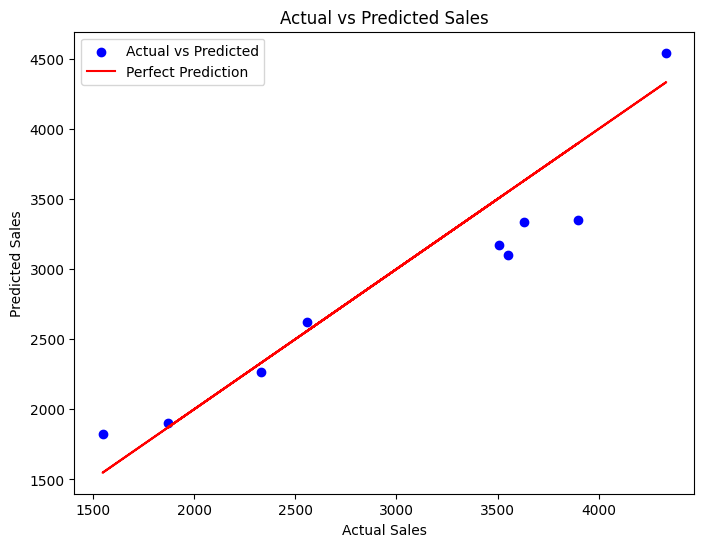

In [14]:

plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, color='blue', label='Actual vs Predicted')
plt.plot(y_test, y_test, color='red', label='Perfect Prediction')  # Perfect prediction line (y_test = predictions)
plt.title('Actual vs Predicted Sales')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.legend()
plt.show()



# LSTM

In [15]:

df = cocacola_df.copy()
# Extract year and quarter, create datetime index

df['Year'] = df['Quarter'].apply(lambda x: int(x.split('_')[1]))
df['Quarter'] = df['Quarter'].apply(lambda x: x.split('_')[0])
df['Date'] = df.apply(lambda x: pd.to_datetime(f'{x["Year"]}-{x["Quarter"][-2:]}'), axis=1)

# Drop unnecessary columns
df.drop(['Quarter', 'Year'], axis=1, inplace=True)
df.set_index('Date', inplace=True)


In [16]:

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append((sequence, target))
    return np.array(sequences)

# Set sequence length and split data into train/test
sequence_length = 4  # Adjust as needed
split = int(len(scaled_data) * 0.8)
train_data = scaled_data[:split]
test_data = scaled_data[split:]

train_sequences = create_sequences(train_data, sequence_length)
test_sequences = create_sequences(test_data, sequence_length)

X_train = np.array([seq[0] for seq in train_sequences])
y_train = np.array([seq[1] for seq in train_sequences])
X_test = np.array([seq[0] for seq in test_sequences])
y_test = np.array([seq[1] for seq in test_sequences])

# Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

# Make predictions
predicted_sales = model.predict(X_test)
predicted_sales = scaler.inverse_transform(predicted_sales)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predicted_sales))
print(f"Root Mean Squared Error (RMSE) for LSTM: {rmse}")


<ipython-input-16-8f3ce466cea2>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(sequences)


1/1 [==============================] - 0s 198ms/step
Root Mean Squared Error (RMSE) for LSTM: 447.9288991388995


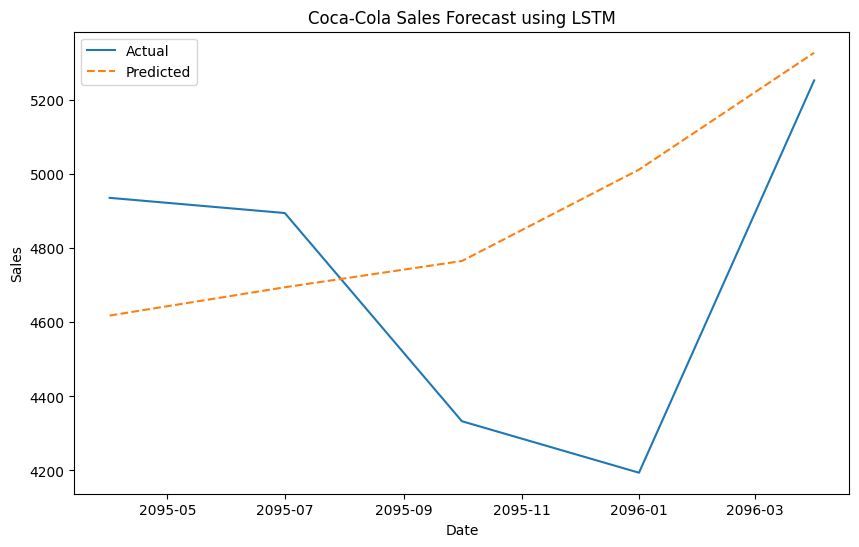

In [17]:


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df.index[-len(y_test):], y_test, label='Actual')
plt.plot(df.index[-len(y_test):], predicted_sales, label='Predicted', linestyle='--')
plt.title('Coca-Cola Sales Forecast using LSTM')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# ARIMA

In [21]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX



# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values.reshape(-1, 1))

# Set sequence length and split data into train/test
sequence_length = 4
split = int(len(scaled_data) * 0.8)
train_data = scaled_data[:split]
test_data = scaled_data[split:]

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append((sequence.flatten(), target[0]))
    return sequences

train_sequences = create_sequences(train_data, sequence_length)
test_sequences = create_sequences(test_data, sequence_length)

X_train = np.array([seq[0] for seq in train_sequences])
y_train = np.array([seq[1] for seq in train_sequences])
X_test = np.array([seq[0] for seq in test_sequences])
y_test = np.array([seq[1] for seq in test_sequences])

# ARIMA Model
arima_model = ARIMA(train_data, order=(5,1,0))
arima_model_fit = arima_model.fit()

# SARIMA Model (assuming it's not used in this version)
# sarima_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
# sarima_model_fit = sarima_model.fit()

# Make predictions for ARIMA
arima_predictions = arima_model_fit.forecast(steps=len(X_test))

# Inverse transform predictions
arima_predictions = scaler.inverse_transform(arima_predictions.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE for ARIMA
arima_rmse = np.sqrt(mean_squared_error(y_test, arima_predictions))
print(f"Root Mean Squared Error (RMSE) for ARIMA: {arima_rmse}")


Root Mean Squared Error (RMSE) for ARIMA: 942.3936701586213


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


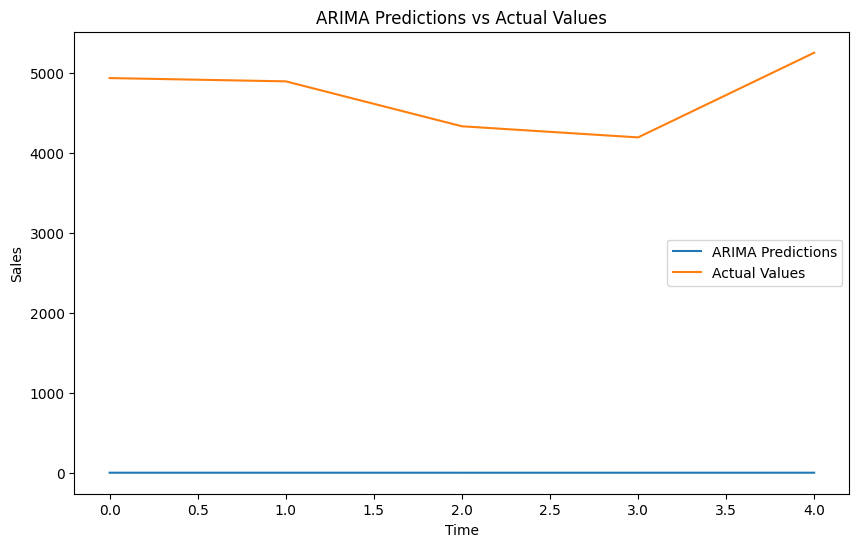

In [36]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(arima_predictions, label='ARIMA Predictions')
plt.plot(y_test, label='Actual Values')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()


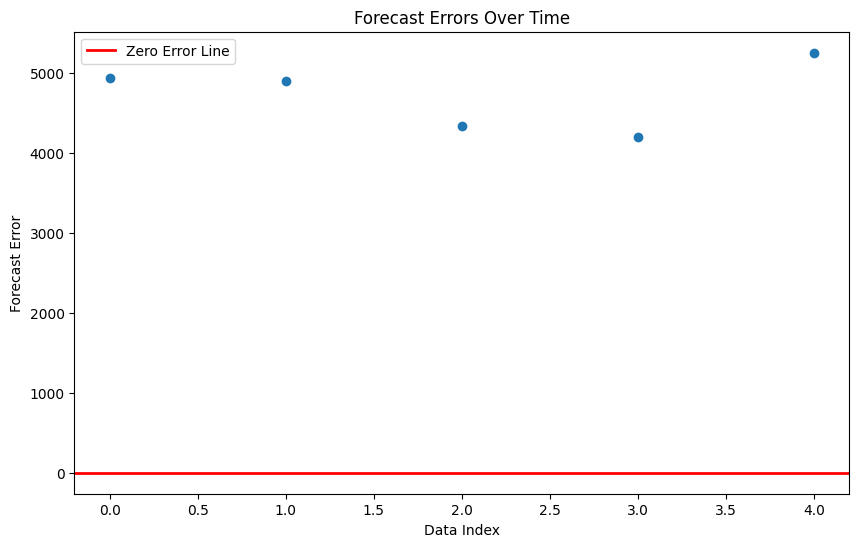

In [37]:
# Calculate forecast errors
forecast_errors = y_test.flatten() - arima_predictions.flatten()

# Plot forecast errors over time
plt.figure(figsize=(10, 6))
plt.plot(forecast_errors, marker='o', linestyle='')
plt.axhline(y=0, color='r', linestyle='-', linewidth=2, label='Zero Error Line')
plt.title('Forecast Errors Over Time')
plt.xlabel('Data Index')
plt.ylabel('Forecast Error')
plt.legend()
plt.show()


# SARIMA

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX



# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values.reshape(-1, 1))

# Set sequence length and split data into train/test
sequence_length = 4
split = int(len(scaled_data) * 0.8)
train_data = scaled_data[:split]
test_data = scaled_data[split:]

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append((sequence.flatten(), target[0]))
    return sequences

train_sequences = create_sequences(train_data, sequence_length)
test_sequences = create_sequences(test_data, sequence_length)

X_train = np.array([seq[0] for seq in train_sequences])
y_train = np.array([seq[1] for seq in train_sequences])
X_test = np.array([seq[0] for seq in test_sequences])
y_test = np.array([seq[1] for seq in test_sequences])

# SARIMA Model
sarima_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_model_fit = sarima_model.fit()

# Make predictions for SARIMA
sarima_predictions = sarima_model_fit.forecast(steps=len(X_test))

# Inverse transform predictions
sarima_predictions = scaler.inverse_transform(sarima_predictions.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
# Calculate RMSE for SARIMA
sarima_rmse = np.sqrt(mean_squared_error(y_test, sarima_predictions))
print(f"Root Mean Squared Error (RMSE) for SARIMA: {sarima_rmse}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Root Mean Squared Error (RMSE) for SARIMA: 942.7605148813228


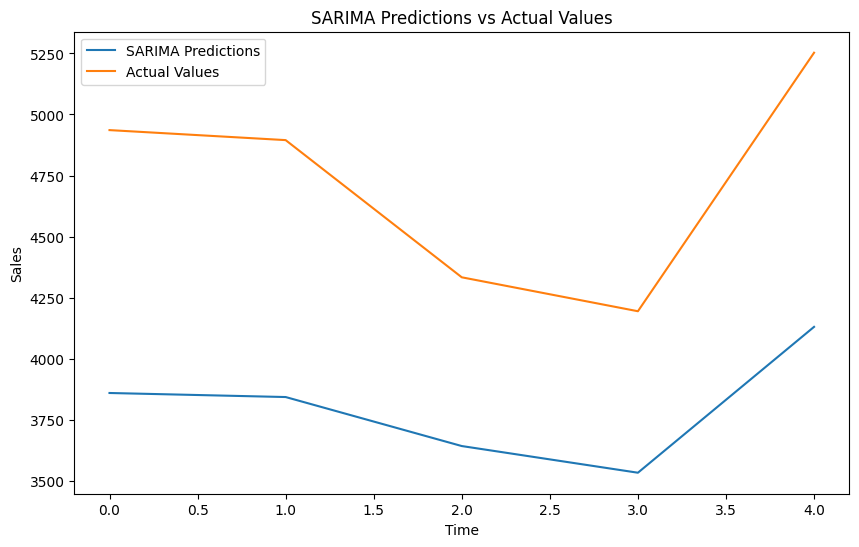

In [28]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(sarima_predictions, label='SARIMA Predictions')
plt.plot(y_test, label='Actual Values')
plt.title('SARIMA Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()


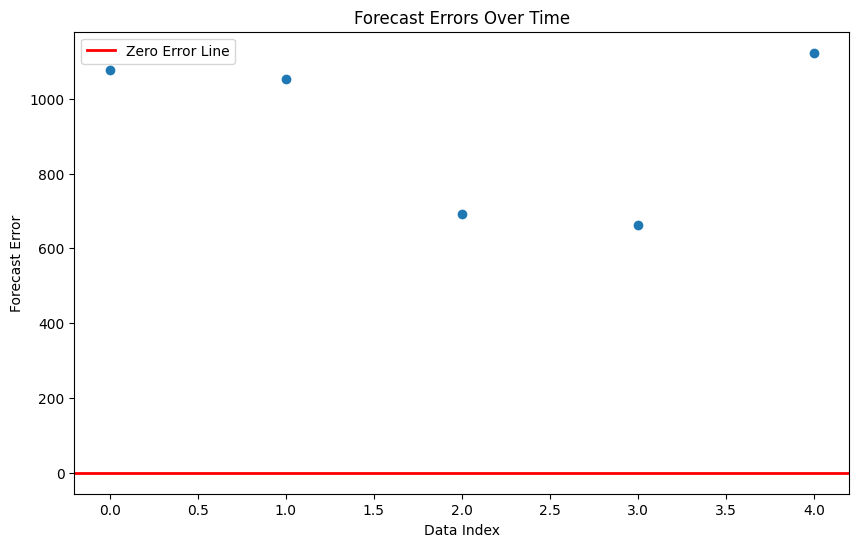

In [35]:
# Calculate forecast errors
forecast_errors = y_test.flatten() - sarima_predictions.flatten()

# Plot forecast errors over time
plt.figure(figsize=(10, 6))
plt.plot(forecast_errors, marker='o', linestyle='')
plt.axhline(y=0, color='r', linestyle='-', linewidth=2, label='Zero Error Line')
plt.title('Forecast Errors Over Time')
plt.xlabel('Data Index')
plt.ylabel('Forecast Error')
plt.legend()
plt.show()


# Conclusion
#### More complex models, such as tree-based models(like random) or neural networks(like LSTMs), might be prone to overfitting, especially when the dataset is limited like our case. Overfitting occurs when a model learns noise from the training data, making it perform poorly on unseen data.
#### Based on the Coco Cola data it is clear that Sales are increasing over years gradually despite of some discrepancies. So a simple linear regression might capture this relationship effectively.
#### From Graphs which are plotted in this notebook it is clearly visible
 #### If the data shows trends or changing statistical properties over time, ARIMA/SARIMA might not effectively model these patterns without further transformations or differencing.